## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [2]:
import warnings

# Suppress the specific PerformanceWarning
warnings.filterwarnings('ignore', message='DataFrame is highly fragmented', category=pd.errors.PerformanceWarning)

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [5]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["AGG","BNDX", "SPY"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df


# Display sample data
df_ticker.head()

,close,high,low,trade_count,open,volume,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,108.730,108.9599,108.620,11009,108.81,2570887,108.743355,AGG
2017-05-02 04:00:00+00:00,108.885,108.9400,108.679,9267,108.68,3001135,108.834423,AGG
2017-05-03 04:00:00+00:00,108.795,108.9900,108.770,10988,108.97,1947037,108.901257,AGG
2017-05-04 04:00:00+00:00,108.680,108.7000,108.550,7505,108.55,1919037,108.630153,AGG
2017-05-05 04:00:00+00:00,108.700,108.7400,108.570,7386,108.72,1451997,108.676418,AGG


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [6]:
# Reorganize the DataFrame
# Separate ticker data
#T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
ticker_one = df_ticker[df_ticker["symbol"]==tickers[0]].drop("symbol", axis=1)
ticker_two = df_ticker[df_ticker["symbol"]==tickers[1]].drop("symbol", axis=1)
ticker_three = df_ticker[df_ticker["symbol"]==tickers[2]].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([ticker_one, ticker_two, ticker_three], axis=1, keys=[tickers[0],tickers[1],tickers[2]])

# Display sample data
df_ticker.head()

AGG                                         \
                             close      high      low trade_count    open   
timestamp                                                                   
2017-05-01 04:00:00+00:00  108.730  108.9599  108.620       11009  108.81   
2017-05-02 04:00:00+00:00  108.885  108.9400  108.679        9267  108.68   
2017-05-03 04:00:00+00:00  108.795  108.9900  108.770       10988  108.97   
2017-05-04 04:00:00+00:00  108.680  108.7000  108.550        7505  108.55   
2017-05-05 04:00:00+00:00  108.700  108.7400  108.570        7386  108.72   

                                                 BNDX                ...  \
                            volume        vwap  close   high    low  ...   
timestamp                                                            ...   
2017-05-01 04:00:00+00:00  2570887  108.743355  54.31  54.42  54.30  ...   
2017-05-02 04:00:00+00:00  3001135  108.834423  54.40  54.40  54.33  ...   
2017-05-03 04:00:00+00:00  1947037  108.901257  54.43  54.47  54.36  ...   
2017-05-04 04:00:00+00:00  1919037  108.630153  54.32  54.38  54.28  ...   
2017-05-05 04:00:00+00:00  1451997  108.676418  54.34  54.38  54.30  ...   

                                                        SPY            \
                            open  volume       vwap   close      high   
timestamp                                                               
2017-05-01 04:00:00+00:00  54.35  696835  54.356257  238.63  239.1700   
2017-05-02 04:00:00+00:00  54.36  920905  54.374054  238.76  238.9800   
2017-05-03 04:00:00+00:00  54.41  667361  54.424534  238.52  238.8775   
2017-05-04 04:00:00+00:00  54.35  517669  54.332298  238.74  238.9225   
2017-05-05 04:00:00+00:00  54.36  692991  54.343478  239.68  239.7200   

                                                                              
                               low trade_count    open    volume        vwap  
timestamp                                                                     
2017-05-01 04:00:00+00:00  238.195      180746  238.68  71024242  238.682861  
2017-05-02 04:00:00+00:00  238.300      176653  238.84  58348712  238.633518  
2017-05-03 04:00:00+00:00  237.700      223575  238.29  78825179  238.420112  
2017-05-04 04:00:00+00:00  237.780      208880  238.83  62308887  238.544823  
2017-05-05 04:00:00+00:00  238.680      203540  239.19  65197733  239.269602  

[5 rows x 21 columns]

### Simulate five year portfolio growth with evenly-distributed stock investments

In [7]:
# Configure a Monte Carlo simulation to forecast specified years and num_sims cumulative returns

# specify the number of simulations to be run and the number of years to be forecast
num_sims = 1000
forecast_years = 5

MC_even_dist = MCSimulation(df_ticker, weights=[1/3,1/3,1/3], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_even_dist.portfolio_data.head()

AGG                                         \
                             close      high      low trade_count    open   
timestamp                                                                   
2017-05-01 04:00:00+00:00  108.730  108.9599  108.620       11009  108.81   
2017-05-02 04:00:00+00:00  108.885  108.9400  108.679        9267  108.68   
2017-05-03 04:00:00+00:00  108.795  108.9900  108.770       10988  108.97   
2017-05-04 04:00:00+00:00  108.680  108.7000  108.550        7505  108.55   
2017-05-05 04:00:00+00:00  108.700  108.7400  108.570        7386  108.72   

                                                              BNDX         \
                            volume        vwap daily_return  close   high   
timestamp                                                                   
2017-05-01 04:00:00+00:00  2570887  108.743355          NaN  54.31  54.42   
2017-05-02 04:00:00+00:00  3001135  108.834423     0.001426  54.40  54.40   
2017-05-03 04:00:00+00:00  1947037  108.901257    -0.000827  54.43  54.47   
2017-05-04 04:00:00+00:00  1919037  108.630153    -0.001057  54.32  54.38   
2017-05-05 04:00:00+00:00  1451997  108.676418     0.000184  54.34  54.38   

                           ...                             SPY            \
                           ...       vwap daily_return   close      high   
timestamp                  ...                                             
2017-05-01 04:00:00+00:00  ...  54.356257          NaN  238.63  239.1700   
2017-05-02 04:00:00+00:00  ...  54.374054     0.001657  238.76  238.9800   
2017-05-03 04:00:00+00:00  ...  54.424534     0.000551  238.52  238.8775   
2017-05-04 04:00:00+00:00  ...  54.332298    -0.002021  238.74  238.9225   
2017-05-05 04:00:00+00:00  ...  54.343478     0.000368  239.68  239.7200   

                                                                              \
                               low trade_count    open    volume        vwap   
timestamp                                                                      
2017-05-01 04:00:00+00:00  238.195      180746  238.68  71024242  238.682861   
2017-05-02 04:00:00+00:00  238.300      176653  238.84  58348712  238.633518   
2017-05-03 04:00:00+00:00  237.700      223575  238.29  78825179  238.420112   
2017-05-04 04:00:00+00:00  237.780      208880  238.83  62308887  238.544823   
2017-05-05 04:00:00+00:00  238.680      203540  239.19  65197733  239.269602   

                                        
                          daily_return  
timestamp                               
2017-05-01 04:00:00+00:00          NaN  
2017-05-02 04:00:00+00:00     0.000545  
2017-05-03 04:00:00+00:00    -0.001005  
2017-05-04 04:00:00+00:00     0.000922  
2017-05-05 04:00:00+00:00     0.003937  

[5 rows x 24 columns]

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

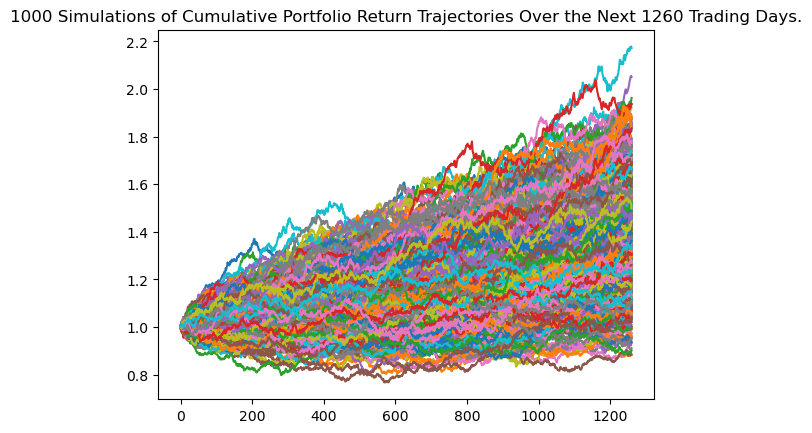

In [8]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
### ***NOTE*** WE NEED TO USE HVPLOT
MC_even_dist.plot_simulation()


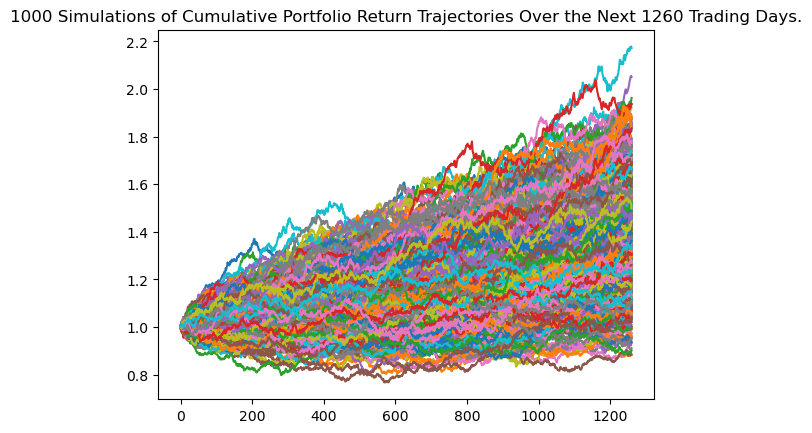

In [9]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

#change the _fiveyear_ sim in the string to reflect the sim length
line_plot.get_figure().savefig('MC_fiveyear_sim_plot.png', bbox_inches='tight')

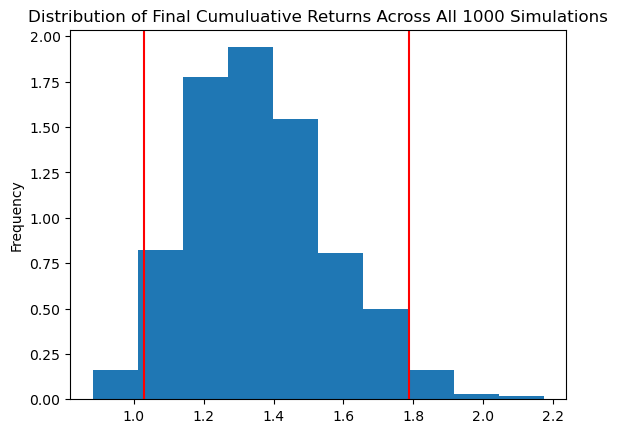

In [10]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [11]:
# Fetch summary statistics from the Monte Carlo simulation results

# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_equal = MC_even_dist.simulated_return.iloc[-1].describe()
ci_series_equal = MC_even_dist.confidence_interval
ci_series_equal.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_equal = pd.concat([summary_metrics_equal, ci_series_equal], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_equal)

count           1000.000000
mean               1.360225
std                0.199928
min                0.883430
25%                1.216166
50%                1.340839
75%                1.483612
max                2.172392
95% CI Lower       1.030881
95% CI Upper       1.787362
Name: 1260, dtype: float64


In [12]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
initial_investment = 15000
lower_bound_equal = round((summary_df_equal['95% CI Lower'] * initial_investment), 2)
upper_bound_equal = round((summary_df_equal['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment}")
print(f"in the portofolio over the next 5 years will end within the range of ${lower_bound_equal} and ${upper_bound_equal}.")

sharpe_equal = summary_df_equal['mean']/summary_df_equal['std']
print(f"this is your sharpe: {round(sharpe_equal, 2)}, you make {round(sharpe_equal,2)} units of return for every 1 unit of risk")

There is a 95% chance that an initial investment of $15000
in the portofolio over the next 5 years will end within the range of $15463.22 and $26810.44.
this is your sharpe: 6.8, you make 6.8 units of return for every 1 unit of risk


### Simulate five year portfolio growth with 60% ticker_two stock

In [13]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_ticker_two_heavy = MCSimulation(df_ticker, weights=[.20,.60,.20], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_ticker_two_heavy.portfolio_data.head()

AGG                                         \
                             close      high      low trade_count    open   
timestamp                                                                   
2017-05-01 04:00:00+00:00  108.730  108.9599  108.620       11009  108.81   
2017-05-02 04:00:00+00:00  108.885  108.9400  108.679        9267  108.68   
2017-05-03 04:00:00+00:00  108.795  108.9900  108.770       10988  108.97   
2017-05-04 04:00:00+00:00  108.680  108.7000  108.550        7505  108.55   
2017-05-05 04:00:00+00:00  108.700  108.7400  108.570        7386  108.72   

                                                              BNDX         \
                            volume        vwap daily_return  close   high   
timestamp                                                                   
2017-05-01 04:00:00+00:00  2570887  108.743355          NaN  54.31  54.42   
2017-05-02 04:00:00+00:00  3001135  108.834423     0.001426  54.40  54.40   
2017-05-03 04:00:00+00:00  1947037  108.901257    -0.000827  54.43  54.47   
2017-05-04 04:00:00+00:00  1919037  108.630153    -0.001057  54.32  54.38   
2017-05-05 04:00:00+00:00  1451997  108.676418     0.000184  54.34  54.38   

                           ...                             SPY            \
                           ...       vwap daily_return   close      high   
timestamp                  ...                                             
2017-05-01 04:00:00+00:00  ...  54.356257          NaN  238.63  239.1700   
2017-05-02 04:00:00+00:00  ...  54.374054     0.001657  238.76  238.9800   
2017-05-03 04:00:00+00:00  ...  54.424534     0.000551  238.52  238.8775   
2017-05-04 04:00:00+00:00  ...  54.332298    -0.002021  238.74  238.9225   
2017-05-05 04:00:00+00:00  ...  54.343478     0.000368  239.68  239.7200   

                                                                              \
                               low trade_count    open    volume        vwap   
timestamp                                                                      
2017-05-01 04:00:00+00:00  238.195      180746  238.68  71024242  238.682861   
2017-05-02 04:00:00+00:00  238.300      176653  238.84  58348712  238.633518   
2017-05-03 04:00:00+00:00  237.700      223575  238.29  78825179  238.420112   
2017-05-04 04:00:00+00:00  237.780      208880  238.83  62308887  238.544823   
2017-05-05 04:00:00+00:00  238.680      203540  239.19  65197733  239.269602   

                                        
                          daily_return  
timestamp                               
2017-05-01 04:00:00+00:00          NaN  
2017-05-02 04:00:00+00:00     0.000545  
2017-05-03 04:00:00+00:00    -0.001005  
2017-05-04 04:00:00+00:00     0.000922  
2017-05-05 04:00:00+00:00     0.003937  

[5 rows x 24 columns]

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

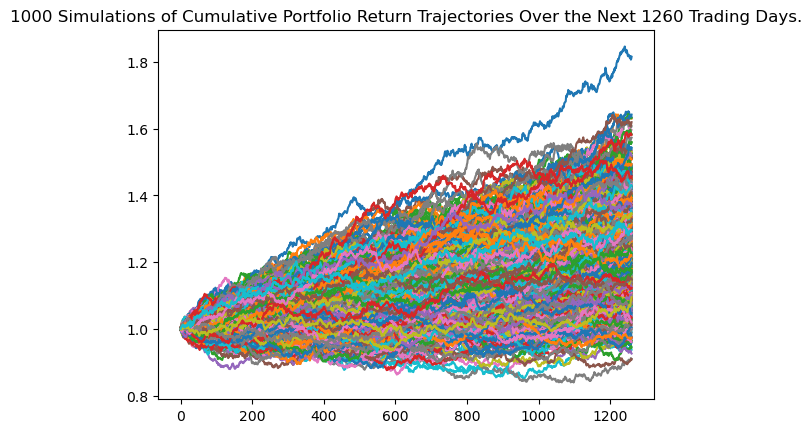

In [14]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_ticker_two_heavy.plot_simulation()

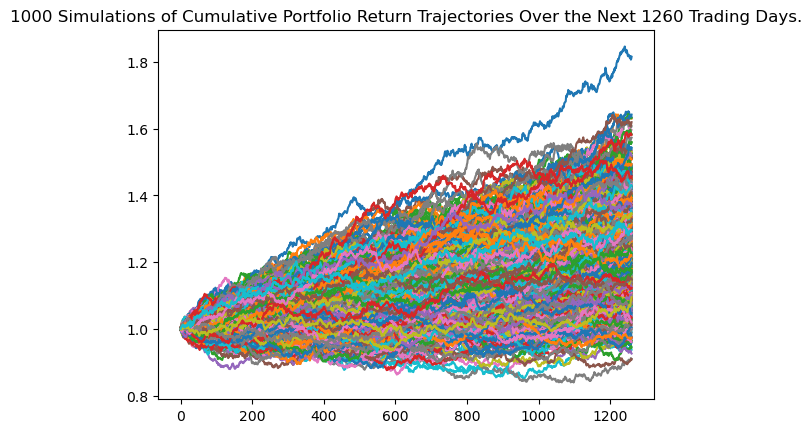

In [15]:
# Plot simulation outcomes
line_plot = MC_ticker_two_heavy.plot_simulation()

line_plot.get_figure().savefig('MC_ATT_fiveyear_sim_plot.png', bbox_inches='tight')

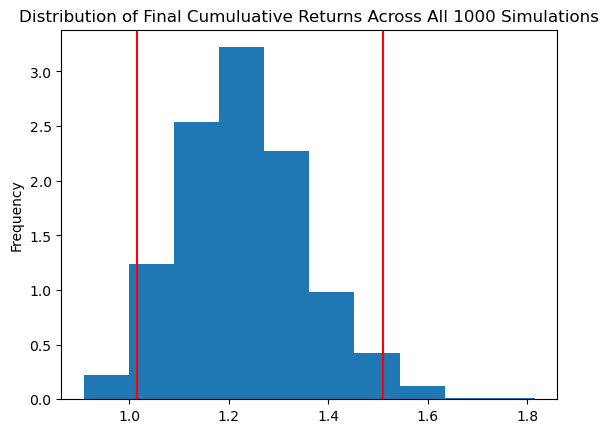

In [16]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ticker_two_heavy.plot_distribution()

dist_plot.get_figure().savefig('MC_att_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [17]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_ticker_two_heavy = MC_ticker_two_heavy.simulated_return.iloc[-1].describe()
ci_series_ticker_two_heavy = MC_ticker_two_heavy.confidence_interval
ci_series_ticker_two_heavy.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_ticker_two_heavy = pd.concat([summary_metrics_ticker_two_heavy, ci_series_ticker_two_heavy], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_ticker_two_heavy)

count           1000.000000
mean               1.229516
std                0.126479
min                0.908838
25%                1.138892
50%                1.222900
75%                1.305723
max                1.815359
95% CI Lower       1.015891
95% CI Upper       1.510862
Name: 1260, dtype: float64


In [18]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_ticker_two_heavy = round((summary_df_ticker_two_heavy['95% CI Lower'] * initial_investment), 2)
upper_bound_ticker_two_heavy = round((summary_df_ticker_two_heavy['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_ticker_two_heavy} and ${upper_bound_ticker_two_heavy}.")


There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $15238.37 and $22662.93.


### Simulate five year portfolio growth with 60% ticker_three stock

In [19]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_ticker_three_heavy = MCSimulation(df_ticker, weights=[.20,.20,.60], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Printing the simulation input data
MC_ticker_three_heavy.portfolio_data.head()

AGG                                         \
                             close      high      low trade_count    open   
timestamp                                                                   
2017-05-01 04:00:00+00:00  108.730  108.9599  108.620       11009  108.81   
2017-05-02 04:00:00+00:00  108.885  108.9400  108.679        9267  108.68   
2017-05-03 04:00:00+00:00  108.795  108.9900  108.770       10988  108.97   
2017-05-04 04:00:00+00:00  108.680  108.7000  108.550        7505  108.55   
2017-05-05 04:00:00+00:00  108.700  108.7400  108.570        7386  108.72   

                                                              BNDX         \
                            volume        vwap daily_return  close   high   
timestamp                                                                   
2017-05-01 04:00:00+00:00  2570887  108.743355          NaN  54.31  54.42   
2017-05-02 04:00:00+00:00  3001135  108.834423     0.001426  54.40  54.40   
2017-05-03 04:00:00+00:00  1947037  108.901257    -0.000827  54.43  54.47   
2017-05-04 04:00:00+00:00  1919037  108.630153    -0.001057  54.32  54.38   
2017-05-05 04:00:00+00:00  1451997  108.676418     0.000184  54.34  54.38   

                           ...                             SPY            \
                           ...       vwap daily_return   close      high   
timestamp                  ...                                             
2017-05-01 04:00:00+00:00  ...  54.356257          NaN  238.63  239.1700   
2017-05-02 04:00:00+00:00  ...  54.374054     0.001657  238.76  238.9800   
2017-05-03 04:00:00+00:00  ...  54.424534     0.000551  238.52  238.8775   
2017-05-04 04:00:00+00:00  ...  54.332298    -0.002021  238.74  238.9225   
2017-05-05 04:00:00+00:00  ...  54.343478     0.000368  239.68  239.7200   

                                                                              \
                               low trade_count    open    volume        vwap   
timestamp                                                                      
2017-05-01 04:00:00+00:00  238.195      180746  238.68  71024242  238.682861   
2017-05-02 04:00:00+00:00  238.300      176653  238.84  58348712  238.633518   
2017-05-03 04:00:00+00:00  237.700      223575  238.29  78825179  238.420112   
2017-05-04 04:00:00+00:00  237.780      208880  238.83  62308887  238.544823   
2017-05-05 04:00:00+00:00  238.680      203540  239.19  65197733  239.269602   

                                        
                          daily_return  
timestamp                               
2017-05-01 04:00:00+00:00          NaN  
2017-05-02 04:00:00+00:00     0.000545  
2017-05-03 04:00:00+00:00    -0.001005  
2017-05-04 04:00:00+00:00     0.000922  
2017-05-05 04:00:00+00:00     0.003937  

[5 rows x 24 columns]

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

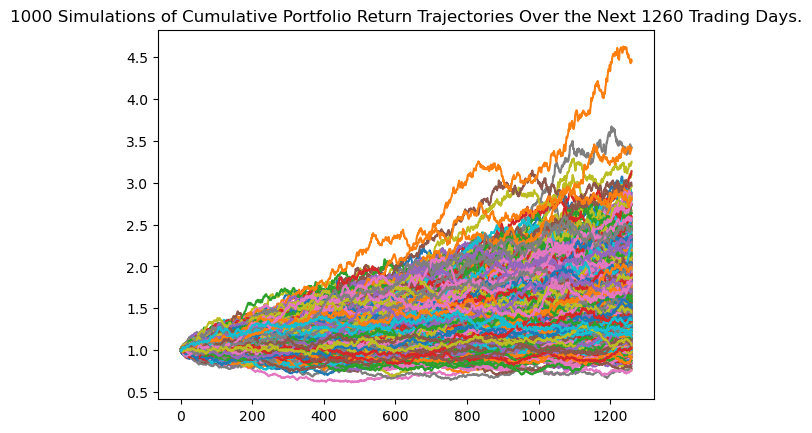

In [20]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_ticker_three_heavy.plot_simulation()

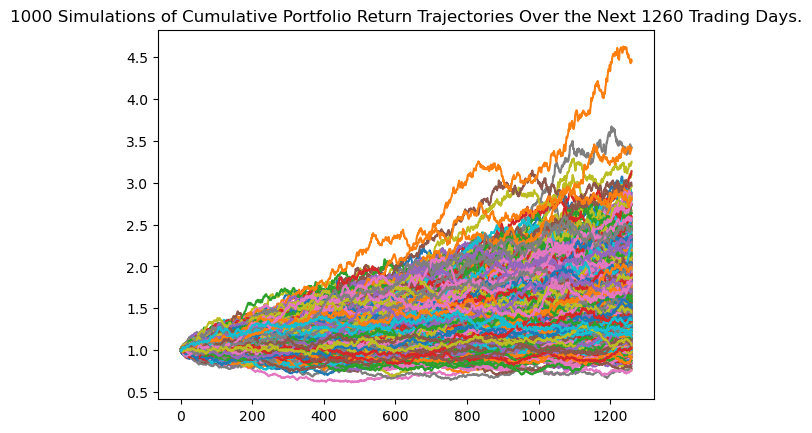

In [21]:
# Plot simulation outcomes
line_plot = MC_ticker_three_heavy.plot_simulation()

line_plot.get_figure().savefig('MC_xom_fiveyear_sim_plot.png', bbox_inches='tight')

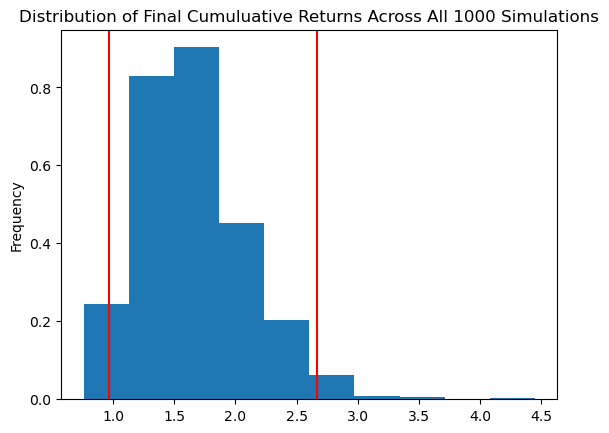

In [22]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ticker_three_heavy.plot_distribution()

dist_plot.get_figure().savefig('MC_nike_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [23]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_ticker_three_heavy = MC_ticker_three_heavy.simulated_return.iloc[-1].describe()
ci_series_ticker_three_heavy = MC_ticker_three_heavy.confidence_interval
ci_series_ticker_three_heavy.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_ticker_three_heavy = pd.concat([summary_metrics_ticker_three_heavy, ci_series_ticker_three_heavy], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_ticker_three_heavy)

count           1000.000000
mean               1.656708
std                0.440391
min                0.760323
25%                1.345992
50%                1.606515
75%                1.894604
max                4.448927
95% CI Lower       0.967840
95% CI Upper       2.667165
Name: 1260, dtype: float64


In [24]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_ticker_three_heavy = round((summary_df_ticker_three_heavy['95% CI Lower'] * initial_investment), 2)
upper_bound_ticker_three_heavy = round((summary_df_ticker_three_heavy['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_ticker_three_heavy} and ${upper_bound_ticker_three_heavy}.")

There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $14517.6 and $40007.48.


### Simulate five year portfolio growth with 60% ticker_one stock

In [25]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_ticker_one_heavy = MCSimulation(df_ticker, weights=[.60,.20,.20], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_ticker_one_heavy.portfolio_data.head()

AGG                                         \
                             close      high      low trade_count    open   
timestamp                                                                   
2017-05-01 04:00:00+00:00  108.730  108.9599  108.620       11009  108.81   
2017-05-02 04:00:00+00:00  108.885  108.9400  108.679        9267  108.68   
2017-05-03 04:00:00+00:00  108.795  108.9900  108.770       10988  108.97   
2017-05-04 04:00:00+00:00  108.680  108.7000  108.550        7505  108.55   
2017-05-05 04:00:00+00:00  108.700  108.7400  108.570        7386  108.72   

                                                              BNDX         \
                            volume        vwap daily_return  close   high   
timestamp                                                                   
2017-05-01 04:00:00+00:00  2570887  108.743355          NaN  54.31  54.42   
2017-05-02 04:00:00+00:00  3001135  108.834423     0.001426  54.40  54.40   
2017-05-03 04:00:00+00:00  1947037  108.901257    -0.000827  54.43  54.47   
2017-05-04 04:00:00+00:00  1919037  108.630153    -0.001057  54.32  54.38   
2017-05-05 04:00:00+00:00  1451997  108.676418     0.000184  54.34  54.38   

                           ...                             SPY            \
                           ...       vwap daily_return   close      high   
timestamp                  ...                                             
2017-05-01 04:00:00+00:00  ...  54.356257          NaN  238.63  239.1700   
2017-05-02 04:00:00+00:00  ...  54.374054     0.001657  238.76  238.9800   
2017-05-03 04:00:00+00:00  ...  54.424534     0.000551  238.52  238.8775   
2017-05-04 04:00:00+00:00  ...  54.332298    -0.002021  238.74  238.9225   
2017-05-05 04:00:00+00:00  ...  54.343478     0.000368  239.68  239.7200   

                                                                              \
                               low trade_count    open    volume        vwap   
timestamp                                                                      
2017-05-01 04:00:00+00:00  238.195      180746  238.68  71024242  238.682861   
2017-05-02 04:00:00+00:00  238.300      176653  238.84  58348712  238.633518   
2017-05-03 04:00:00+00:00  237.700      223575  238.29  78825179  238.420112   
2017-05-04 04:00:00+00:00  237.780      208880  238.83  62308887  238.544823   
2017-05-05 04:00:00+00:00  238.680      203540  239.19  65197733  239.269602   

                                        
                          daily_return  
timestamp                               
2017-05-01 04:00:00+00:00          NaN  
2017-05-02 04:00:00+00:00     0.000545  
2017-05-03 04:00:00+00:00    -0.001005  
2017-05-04 04:00:00+00:00     0.000922  
2017-05-05 04:00:00+00:00     0.003937  

[5 rows x 24 columns]

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

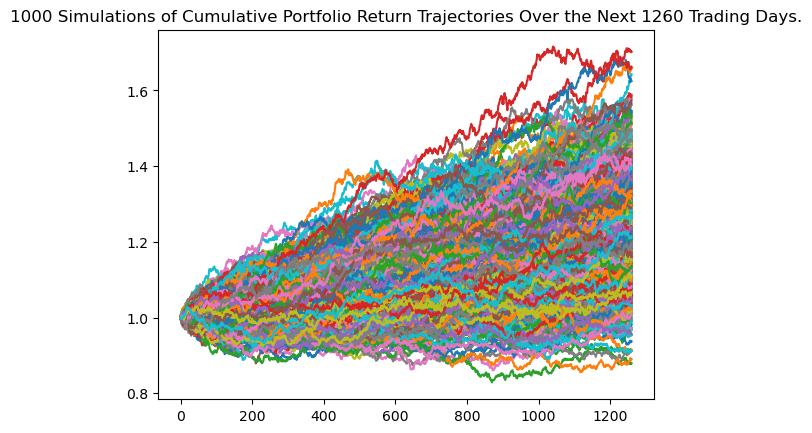

In [26]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_ticker_one_heavy.plot_simulation()

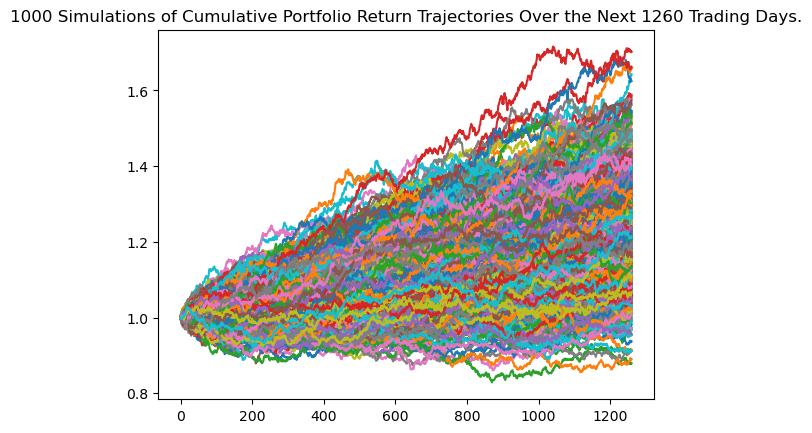

In [27]:
# Plot simulation outcomes
line_plot = MC_ticker_one_heavy.plot_simulation()

line_plot.get_figure().savefig('MC_nike_fiveyear_sim_plot.png', bbox_inches='tight')

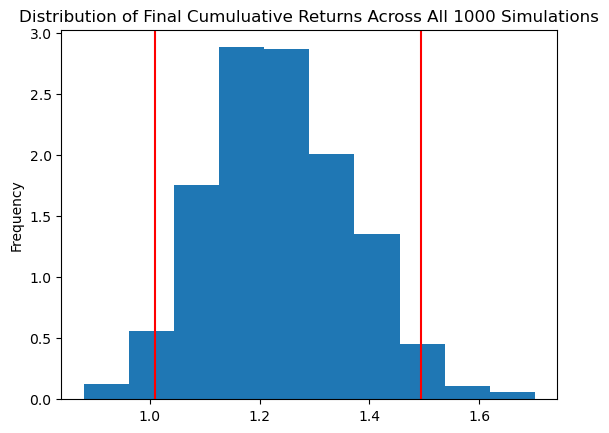

In [28]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ticker_one_heavy.plot_distribution()

dist_plot.get_figure().savefig('MC_nike_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [29]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_ticker_one_heavy = MC_ticker_one_heavy.simulated_return.iloc[-1].describe()
ci_series_ticker_one_heavy = MC_ticker_one_heavy.confidence_interval
ci_series_ticker_one_heavy.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_ticker_one_heavy = pd.concat([summary_metrics_ticker_one_heavy, ci_series_ticker_one_heavy], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_ticker_one_heavy)

count           1000.000000
mean               1.235980
std                0.130518
min                0.879599
25%                1.143827
50%                1.227563
75%                1.322192
max                1.701817
95% CI Lower       1.009925
95% CI Upper       1.494104
Name: 1260, dtype: float64


In [30]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_ticker_one_heavy = round((summary_df_ticker_one_heavy['95% CI Lower'] * initial_investment), 2)
upper_bound_ticker_one_heavy = round((summary_df_ticker_one_heavy['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_ticker_one_heavy} and ${upper_bound_ticker_one_heavy}.")

There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $15148.87 and $22411.55.


### Summarize findings across all 4 simulations

In [31]:
# set equal portfolio metrics
risk_reward_equal = round((upper_bound_equal - initial_investment)/abs(lower_bound_equal - initial_investment), 2)
sharpe = summary_df_equal['mean']/summary_df_equal['std']
risk_adjusted_efficiency_equal = round((risk_reward_equal / sharpe), 2)

# set heavy ticker_one metrics
risk_reward_ticker_one_heavy = round((upper_bound_ticker_one_heavy - initial_investment)/abs(lower_bound_ticker_one_heavy - initial_investment), 2)
sharpe_ticker_one_heavy = summary_df_ticker_one_heavy['mean']/summary_df_ticker_one_heavy['std']
risk_adjusted_efficiency_ticker_one_heavy = round((risk_reward_ticker_one_heavy / sharpe_ticker_one_heavy), 2)

# set heavy ticker_two metrics
risk_reward_ticker_two_heavy = round((upper_bound_ticker_two_heavy - initial_investment)/abs(lower_bound_ticker_two_heavy - initial_investment), 2)
sharpe_ticker_two_heavy = summary_df_ticker_two_heavy['mean']/summary_df_ticker_two_heavy['std']
risk_adjusted_efficiency_ticker_two_heavy = round((risk_reward_ticker_two_heavy / sharpe_ticker_two_heavy), 2)

# set heavy ticker_three metrics
risk_reward_ticker_three_heavy = round((upper_bound_ticker_three_heavy - initial_investment)/abs(lower_bound_ticker_three_heavy - initial_investment), 2)
sharpe_ticker_three_heavy = summary_df_ticker_three_heavy['mean']/summary_df_ticker_three_heavy['std']
risk_adjusted_efficiency_ticker_three_heavy = round((risk_reward_ticker_three_heavy / sharpe_ticker_three_heavy), 2)

In [32]:
print(f"Initial Investment: ${initial_investment}")

print("--------------")
print(f'Upper and Lower Bounds of Equal Weighted: ${upper_bound_equal} and ${lower_bound_equal}')
print(f"Equal Weighted Max Profit: ${upper_bound_equal - initial_investment}")
print(f"Equal Weighted Max Loss: $ {lower_bound_equal - initial_investment}")
print(f"Equal Weighted Risk-Reward Ratio: {risk_reward_equal}")
print(f"Equal Weighted Simulation Sharpe: {round(sharpe, 2)}")
print(f"Equal Weighted Risk-Adjusted Efficiency: {risk_adjusted_efficiency_equal}")

print("--------------")

print(f"Upper and Lower Bounds of Heavy {tickers[0]} Weighted: ${upper_bound_ticker_one_heavy} and ${lower_bound_ticker_one_heavy}")
print(f"Heavy {tickers[0]} Profit: ${upper_bound_ticker_one_heavy - initial_investment}")
print(f"Heavy {tickers[0]} max loss: $ {lower_bound_ticker_one_heavy - initial_investment}")
print(f"Heavy {tickers[0]} Risk-Reward Ratio: {risk_reward_ticker_one_heavy}")
print(f"Heavy {tickers[0]} Simulation Sharpe: {round(sharpe_ticker_one_heavy, 2)}")
print(f"Heavy {tickers[0]} Risk-Adjusted Efficiency: {risk_adjusted_efficiency_ticker_one_heavy}")

print("--------------")

print(f"Upper and Lower bounds of Heavy {tickers[1]} Weighted: ${upper_bound_ticker_two_heavy} and ${lower_bound_ticker_two_heavy}")
print(f"Heavy {tickers[1]} Max Profit: ${upper_bound_ticker_two_heavy - initial_investment}")
print(f"Heavy {tickers[1]} Max Loss: $ {lower_bound_ticker_two_heavy - initial_investment}")
print(f"Heavy {tickers[1]} Risk-Reward Ratio: {risk_reward_ticker_two_heavy}")
print(f"Heavy {tickers[1]} Simulation Sharpe: {round(sharpe_ticker_two_heavy, 2)}")
print(f"Heavy {tickers[1]} Risk-Adjusted Efficiency: {risk_adjusted_efficiency_ticker_two_heavy}")

print("--------------")

print(f"Upper and Lower Bounds of Heavy {tickers[2]} Weighted: ${upper_bound_ticker_three_heavy} and ${lower_bound_ticker_three_heavy}")
print(f"Heavy {tickers[2]} Max Profit: ${upper_bound_ticker_three_heavy - initial_investment}")
print(f"Heavy {tickers[2]} Max Loss: $ {lower_bound_ticker_three_heavy - initial_investment}")
print(f"Heavy {tickers[2]} Risk-Reward Ratio: {risk_reward_ticker_three_heavy}")
print(f"Heavy {tickers[2]} Simulation Sharpe: {round(sharpe_ticker_three_heavy, 2)}")
print(f"Heavy {tickers[2]} Risk-Adjusted Efficiency: {risk_adjusted_efficiency_ticker_three_heavy}")

Initial Investment: $15000
--------------
Upper and Lower Bounds of Equal Weighted: $26810.44 and $15463.22
Equal Weighted Max Profit: $11810.439999999999
Equal Weighted Max Loss: $ 463.21999999999935
Equal Weighted Risk-Reward Ratio: 25.5
Equal Weighted Simulation Sharpe: 6.8
Equal Weighted Risk-Adjusted Efficiency: 3.75
--------------
Upper and Lower Bounds of Heavy AGG Weighted: $22411.55 and $15148.87
Heavy AGG Profit: $7411.549999999999
Heavy AGG max loss: $ 148.8700000000008
Heavy AGG Risk-Reward Ratio: 49.79
Heavy AGG Simulation Sharpe: 9.47
Heavy AGG Risk-Adjusted Efficiency: 5.26
--------------
Upper and Lower bounds of Heavy BNDX Weighted: $22662.93 and $15238.37
Heavy BNDX Max Profit: $7662.93
Heavy BNDX Max Loss: $ 238.3700000000008
Heavy BNDX Risk-Reward Ratio: 32.15
Heavy BNDX Simulation Sharpe: 9.72
Heavy BNDX Risk-Adjusted Efficiency: 3.31
--------------
Upper and Lower Bounds of Heavy SPY Weighted: $40007.48 and $14517.6
Heavy SPY Max Profit: $25007.480000000003
Heavy 